In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import f1_score
import time
import os
import pylab as pl
import matplotlib.pyplot as plt
from torch.nn.modules import loss
%matplotlib inline

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(20, 16), dpi=80)

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

In [ ]:
class MNISTdataset(Dataset):

    def __init__(self, X,Y,onehot=False):
      #reshaping and normalizing 
        self.onehot = onehot
        self.X = X/255
        if len(X.shape) != 4:
          self.X = self.X.reshape(self.X.shape[0],1,28,28)
        
        self.Y = Y.type(torch.LongTensor)
        if onehot:
          self.Y = F.one_hot(self.Y)
          self.Y = self.Y.type(torch.float32)
    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        x = self.X[idx,:,:]
        y = self.Y[idx]
        return x, y

class CONVNET(nn.Module):
  def __init__(self,BATCH,out_features = 10):
    super().__init__()
    self.batch = BATCH
    self.target_size = out_features

    self.conv1 = nn.Conv2d(in_channels = 1,out_channels = 32,kernel_size = 5,stride = 1)
    self.conv2 = nn.Conv2d(in_channels = 32,out_channels = 64,kernel_size = 5)
    self.conv3 = nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,stride = 1)
    self.conv4 = nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3)
    self.dropout2d = nn.Dropout2d(0.2)
    self.dropout1 = nn.Dropout(0.6)
    self.batch_norm_1 = nn.BatchNorm2d(num_features=32)
    self.batch_norm_2 = nn.BatchNorm2d(num_features=256)
    self.dense1 = nn.Linear(in_features = 2304,out_features = 512 )
    self.dense2 = nn.Linear(in_features = 512,out_features = self.target_size )
  def forward(self,x):
    x = self.conv1(x)
    x = self.batch_norm_1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.max_pool2d(x,2)
    x = F.relu(x)
    x = self.conv3(x)
    x = self.dropout2d(x)
    x = F.relu(x)
    x = self.conv4(x)
    x = F.max_pool2d(x,2)
    x = self.batch_norm_2(x)
    x = F.relu(x)
    
    x = torch.flatten(x,1)
    x = self.dense1(x)
    x = F.relu(x)
    x = self.dropout1(x)
    x = self.dense2(x)
    
   
    return x
def train_one_epoch(model, dataloader, loss_fn, optimiser, device):
  model.train()
  train_loss = []
  for inputs, targets in dataloader:
    inputs = inputs.float()
    if device=='cuda':
      
      inputs , targets = inputs.cuda(), targets.cuda()
    

    # calculate loss
    preds = model(inputs)#hidden)
    
    loss = loss_fn(preds,targets)

    # backpropagate loss and update weights
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    train_loss += [loss.item()]
  print(f"train_loss : {np.mean(train_loss)}")
  return np.mean(train_loss)
  
def validation(model, dataloader, loss_fn,device):
  losses = []
  accuracy = []
  model.eval()
  
  for inputs,targets in dataloader:
      inputs  = inputs.float()
      if device=="cuda":
        inputs , targets = inputs.cuda(), targets.cuda()
      
      # calculate loss
      preds = model(inputs)
      loss = loss_fn(preds,targets)
      losses.append(loss.item())

      
      preds = preds.cpu().detach().numpy()
      x_p = np.argmax(preds,axis=-1)
      x_t = targets.cpu().detach().numpy()#.reshape(-1)
      try:
        if x_t.shape[1] == 2:
          x_t = x_t[:,-1]
      except Exception as e:
        pass
      accu = accuracy_score(x_t,x_p)
      accuracy.append(accu)


  print(f"val_loss_mean : {np.mean(losses)}" + f"\t mean_accuracy: {np.mean(accuracy)}")
  
  return np.mean(losses), np.mean(accuracy)

def test(model, test_dataloader):
  
  model.eval()
  
  Preds = []
  Targets = []
  for inputs,targets in test_dataloader:
      inputs  = inputs.float()
      if device=="cuda":
        inputs , targets = inputs.cuda(), targets.cuda()
      preds = model(inputs)
      preds = preds.cpu().detach().numpy()
      x_p = np.argmax(preds,axis=-1).tolist()
      x_t = targets.cpu().detach().numpy().reshape(-1).tolist()
      Preds += x_p
      Targets += x_t
 
  f1 = f1_score(y_true=Targets, y_pred=Preds ,  average="weighted")
  accu = accuracy_score(Targets,Preds) 
  print("Label: {}".format(Targets))
  print("Preds: {}".format(Preds))
  print("\n") 
  print(f"testing accuracy : {accu}" + f"\t f1_score: {f1}")
  cm = confusion_matrix(Targets,Preds)
  pl.matshow(cm)
  pl.title('Confusion matrix  Fashion MNIST')
  pl.colorbar()
  return 

 
  
def load_latest_model(model, name="model.pt",device='cpu'):
    
    
    model.load_state_dict(torch.load(name,map_location=torch.device(device)))
    return model

def train(model, train_dataloader, test_dataloader,
          epochs, optimizer, criterion, scheduler=None,
          name="model.pth", path=None):


    # compare overfitted
    train_loss_data, valid_loss_data,accuracy_data = [], [] , []
    # check for validation loss
    valid_loss_min = np.Inf
    # calculate time
    since = time.time()

    device = ("cuda" if torch.cuda.is_available() else "cpu")

    for epoch in range(epochs):
        print("Epoch: {}/{}".format(epoch + 1, epochs))
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0
        accu =0
        total = 0
        
        e_since = time.time()

        ###################
        # train the model #
        ###################
        
        train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
        
        ######################
        # validate the model #
        ######################
        print("\t\tGoing for validation")
        valid_loss, accuracy = validation(model, test_dataloader, criterion,device)
        

        # print training/validation statistics
        # calculate average loss over an epoch

        # calculate train loss and running loss
        train_loss_data.append(train_loss)
        valid_loss_data.append(valid_loss)
        accuracy_data.append(accuracy*100)

        print("\tTrain loss:{:.6f}..".format(train_loss),
              "\tValid Loss:{:.6f}..".format(valid_loss),
              "\tAccuracy: {:.4f}".format(accuracy))

        if scheduler is not None:
            scheduler.step(valid_loss)  # step up scheduler

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            torch.save(model.state_dict(), name)
            valid_loss_min = valid_loss
            # save to google drive
            if path is not None:
                torch.save(model.state_dict(), path)

        # Time take for one epoch
        time_elapsed = time.time() - e_since
        print('\tEpoch:{} completed in {:.0f}m {:.0f}s'.format(
            epoch + 1, time_elapsed // 60, time_elapsed % 60))

    # compare total time
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model
    model = load_latest_model(model, name)

    # return the model
    return [model, train_loss_data, valid_loss_data, accuracy_data]



def plot_dataset(dataset,nums = 2):
  data = dataset.data.numpy()
  labels = dataset.targets.numpy().tolist()
  index = np.random.randint( 0,data.shape[0]-1,nums)
  width=28
  height=28
  rows = int(nums/2);
  cols = 2
  axes=[]
  fig=plt.figure()

  for a in range(rows*cols):
    b = data[index[a]]
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("label "+str(labels[index[a]]))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b)
  fig.tight_layout()    
  plt.show()


In [ ]:
# will be using only 10K images for train and test
def prepare_data(data,labels, test_split=0.15,val_split=0.05,shuffle =False,onehot=False ):
  #split train test 
  x_train,x_test,y_train,y_test = train_test_split(data,labels,test_size=test_split ,shuffle=shuffle)   #85/15 split
  x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=val_split )   #keep some for validation
  #preprocess and reshape and create an iterator class
  train_set = MNISTdataset(x_train,y_train,onehot)
  test_set = MNISTdataset(x_test,y_test,onehot)
  val_set = MNISTdataset(x_val,y_val,onehot)
  #creating an iterator 
  train_dataloader = DataLoader(train_set, batch_size=BATCH, shuffle=True)
  test_dataloader = DataLoader(test_set, batch_size=BATCH, shuffle=True)
  val_dataloader = DataLoader(val_set, batch_size=BATCH, shuffle=True)

  print(f"train size {len(train_set)} ")
  print(f"test size {len(test_set)}")
  print(f"validation set size {len(val_set)}")

  return train_dataloader,val_dataloader,test_dataloader

In [ ]:
#set parameters

BATCH = 32
epochs = 25
path = '/content'
model_path = '/content/model.pth'
device = ('cuda' if torch.cuda.is_available() else 'cpu')

learning_rate = 1e-3


In [ ]:
#download data

dataset = datasets.FashionMNIST(download=True,root='/content',train=True )

data = dataset.data.reshape(dataset.data.shape[0],784)

labels = dataset.targets

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [ ]:
#run below cells sequentially

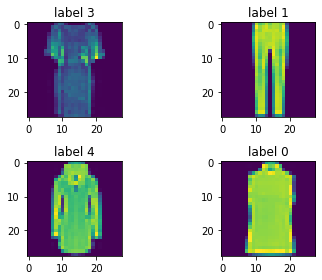

In [ ]:
#lets see some of the images
plot_dataset(dataset,nums=4)

In [ ]:
#model 1

train_dataloader,val_dataloader,test_dataloader = prepare_data(data,labels)
model1 = CONVNET(BATCH)
if torch.cuda.is_available():
  model1.cuda()


loss1 = nn.CrossEntropyLoss()
opt1 = optim.Adam(model1.parameters(),lr=learning_rate)
schedular1 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt1,patience = 5) 


train size 48450 
test size 9000
validation set size 2550


Epoch: 1/25
train_loss : 0.544590782750361
		Going for validation
val_loss_mean : 0.3614574931033537	 mean_accuracy: 0.865802304964539
	Train loss:0.544591.. 	Valid Loss:0.361457.. 	Accuracy: 0.8658
	Validation loss decreased (inf --> 0.361457).  Saving model ...
	Epoch:1 completed in 0m 22s
Epoch: 2/25
train_loss : 0.3760452200280558
		Going for validation
val_loss_mean : 0.29323812419588263	 mean_accuracy: 0.897052304964539
	Train loss:0.376045.. 	Valid Loss:0.293238.. 	Accuracy: 0.8971
	Validation loss decreased (0.361457 --> 0.293238).  Saving model ...
	Epoch:2 completed in 0m 25s
Epoch: 3/25
train_loss : 0.32677862174046707
		Going for validation
val_loss_mean : 0.2988076298266438	 mean_accuracy: 0.8960549645390071
	Train loss:0.326779.. 	Valid Loss:0.298808.. 	Accuracy: 0.8961
	Epoch:3 completed in 0m 23s
Epoch: 4/25
train_loss : 0.29353885414699715
		Going for validation
val_loss_mean : 0.27668599408542643	 mean_accuracy: 0.8973847517730497
	Train loss:0.293539.. 	Valid Loss:0.

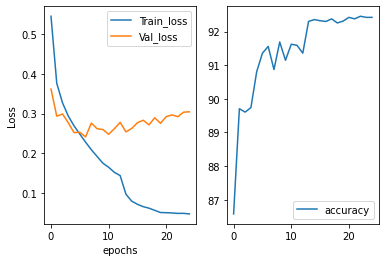

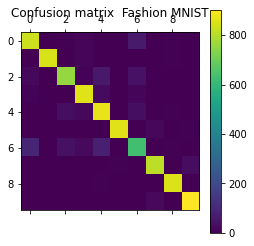

In [ ]:
history1=train(model1,train_dataloader,val_dataloader,epochs,opt1,loss1,schedular1)
model1,l1,l2,a3 = history1
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(l1,label="Train_loss")
ax1.plot(l2,label="Val_loss")
ax1.set_xlabel('epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(a3,label="accuracy")
ax2.legend()

test(model1,test_dataloader)

Label: [8, 1, 3, 3, 3, 4, 0, 0, 6, 5, 8, 2, 7, 5, 6, 9, 5, 7, 0, 9, 1, 5, 8, 9, 4, 7, 0, 3, 3, 8, 4, 4, 0, 8, 3, 3, 2, 0, 6, 1, 5, 3, 7, 3, 6, 0, 6, 6, 2, 0, 3, 0, 1, 6, 1, 8, 1, 7, 2, 3, 6, 8, 1, 3, 3, 2, 0, 9, 5, 9, 3, 7, 3, 8, 1, 1, 7, 6, 2, 3, 3, 2, 9, 8, 9, 9, 2, 6, 2, 9, 2, 7, 0, 9, 0, 7, 8, 5, 4, 0, 0, 9, 1, 7, 4, 5, 0, 5, 5, 4, 2, 8, 3, 4, 1, 2, 8, 0, 7, 2, 7, 2, 0, 2, 1, 3, 6, 4, 7, 6, 6, 5, 0, 9, 5, 3, 5, 5, 1, 7, 4, 7, 3, 5, 8, 9, 6, 7, 1, 9, 7, 2, 8, 6, 1, 9, 1, 9, 3, 9, 5, 7, 4, 0, 2, 1, 3, 6, 5, 2, 1, 9, 1, 0, 9, 6, 2, 6, 8, 4, 2, 4, 4, 6, 3, 1, 1, 5, 8, 7, 4, 3, 4, 3, 6, 4, 1, 4, 4, 5, 4, 0, 7, 6, 3, 4, 2, 7, 0, 5, 6, 9, 4, 4, 7, 1, 1, 0, 3, 3, 4, 4, 4, 7, 3, 1, 9, 1, 8, 1, 8, 8, 6, 0, 8, 6, 5, 5, 6, 0, 4, 3, 9, 6, 2, 8, 5, 5, 0, 7, 3, 6, 1, 2, 0, 7, 6, 7, 0, 2, 4, 2, 6, 0, 2, 7, 8, 3, 3, 1, 1, 4, 3, 2, 2, 8, 9, 8, 2, 5, 1, 2, 0, 8, 0, 4, 0, 9, 5, 5, 7, 8, 1, 9, 0, 3, 5, 0, 8, 8, 4, 6, 0, 0, 0, 8, 5, 6, 4, 7, 6, 9, 1, 3, 9, 1, 1, 4, 2, 7, 4, 4, 3, 7, 8, 6, 2, 0, 8, 5, 0,

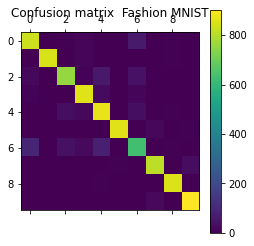

In [ ]:

load_latest_model(model1, name="/content/model.pth",device=device)
test(model1,test_dataloader)

In [ ]:
def binary_oversample(data,labels,class_index=1,size = 10000):
  labels = labels.numpy()
  data = data.numpy().tolist()
  labels = np.where(labels==class_index,1,0).tolist()

  cls_1 = [i for i,e in enumerate(labels) if e == 1]
  cls_2 = [i for i,e in enumerate(labels) if e != 1]
  labels2 = []
  data2 = []
  flag = True
  
  while(len(labels2)!=size):
    if flag:
      index = np.random.choice(cls_1)
      labels2.append(labels[index])
      data2.append(data[index])
      flag = False
    else:
      index = np.random.choice(cls_2)
      labels2.append(labels[index])
      data2.append(data[index])
      flag = True

  return np.array(data2),torch.tensor(labels2)

In [ ]:
data2,labels2 = binary_oversample(data,labels,class_index=6,size = 10000)

In [ ]:
#model 2
#
train_dataloader_2,val_dataloader_2,test_dataloader_2 = prepare_data(data2,labels2,shuffle=True,onehot=True)
model2 = CONVNET(BATCH,out_features = 2)
if torch.cuda.is_available():
  model2.cuda().float()
else:
  model2.float()


loss2 = nn.BCEWithLogitsLoss()
opt2 = optim.Adam(model2.parameters(),lr=learning_rate)
schedular2 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt2,patience = 3) 


train size 8075 
test size 1500
validation set size 425


In [ ]:
for i,j in train_dataloader_2:
  print(j.shape)
  j = j.float()
  print(j.shape)
  p = model2(i.float())
  loss2(p,j)
  break

In [ ]:
j

Epoch: 1/25
train_loss : 0.4525882452137385
		Going for validation
val_loss_mean : 0.37224072005067554	 mean_accuracy: 0.8157242063492064
	Train loss:0.452588.. 	Valid Loss:0.372241.. 	Accuracy: 0.8157
	Validation loss decreased (inf --> 0.372241).  Saving model ...
	Epoch:1 completed in 0m 4s
Epoch: 2/25
train_loss : 0.37863113851886493
		Going for validation
val_loss_mean : 0.3486633130482265	 mean_accuracy: 0.8256448412698413
	Train loss:0.378631.. 	Valid Loss:0.348663.. 	Accuracy: 0.8256
	Validation loss decreased (0.372241 --> 0.348663).  Saving model ...
	Epoch:2 completed in 0m 4s
Epoch: 3/25
train_loss : 0.32077104077037616
		Going for validation
val_loss_mean : 0.30082001430647715	 mean_accuracy: 0.8489583333333333
	Train loss:0.320771.. 	Valid Loss:0.300820.. 	Accuracy: 0.8490
	Validation loss decreased (0.348663 --> 0.300820).  Saving model ...
	Epoch:3 completed in 0m 4s
Epoch: 4/25
train_loss : 0.2864251492522922
		Going for validation
val_loss_mean : 0.31870768857853754	 

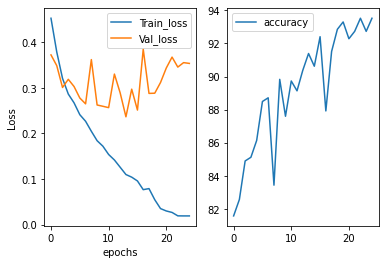

In [ ]:
history2=train(model2,train_dataloader_2,val_dataloader_2,epochs,opt2,loss2,schedular2,name="model2.pth")
model2,l1,l2,a3 = history2
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(l1,label="Train_loss")
ax1.plot(l2,label="Val_loss")
ax1.set_xlabel('epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(a3,label="accuracy")
ax2.legend()



In [ ]:
test(model2,test_dataloader_2)

In [ ]:
#### load the previously trained models 

In [ ]:
test(model2,test_dataloader_2)


In [ ]:
model1 = CONVNET(BATCH,out_features = 10)
load_latest_model(model1, name="/content/model.pth",device=device)
model1.float()


CONVNET(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout2d): Dropout2d(p=0.2, inplace=False)
  (dropout1): Dropout(p=0.6, inplace=False)
  (batch_norm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense1): Linear(in_features=2304, out_features=512, bias=True)
  (dense2): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
model2 = CONVNET(BATCH,out_features = 2)
load_latest_model(model2, name="/content/model2.pth",device=device)
model2.float()

CONVNET(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout2d): Dropout2d(p=0.2, inplace=False)
  (dropout1): Dropout(p=0.6, inplace=False)
  (batch_norm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense1): Linear(in_features=2304, out_features=512, bias=True)
  (dense2): Linear(in_features=512, out_features=2, bias=True)
)

In [ ]:
# next we try an ensemble based model of the previous base model and a new model trained on only major missclassified labels

CONVNET(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout2d): Dropout2d(p=0.2, inplace=False)
  (dropout1): Dropout(p=0.6, inplace=False)
  (batch_norm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense1): Linear(in_features=2304, out_features=512, bias=True)
  (dense2): Linear(in_features=512, out_features=2, bias=True)
)

In [ ]:
class Ensemble1(nn.Module):
  def __init__(self,model1,model2,output_sizes= [10,2]):
    super().__init__()
    self.p1 = model1
    self.p2 = model2
    self.output_sizes=  output_sizes
    #self.set_trainable_false(self.p1)
    #self.set_trainable_false(self.p2)
    self.d11 = nn.Linear(in_features= self.output_sizes[0],out_features = 32)
    self.d12 = nn.Linear(in_features= self.output_sizes[1],out_features = 32)
    self.d2 = nn.Linear(in_features = 32*2, out_features = 128)
    self.d3 = nn.Linear(in_features = 128, out_features = self.output_sizes[0])
    self.dropout = nn.Dropout(0.4)
    
  def set_trainable_false(self,model):
    for param in model.parameters():
      param.requires_grad = False
    

  def forward(self,x):
    x1 = self.p1(x)
    x1 = self.d11(x1)
    x1 = F.relu(x1)

    x2 = self.p2(x)
    x2 = self.d12(x2)
    x2 = F.relu(x2)

    x = torch.cat((x1,x2),dim=-1)
    x = F.relu(self.dropout(self.d2(x)))
    x = self.d3(x)
    return x



In [ ]:
ens = Ensemble1(model1,model2)
if torch.cuda.is_available():
  ens.cuda()
ens.float()

Ensemble1(
  (p1): CONVNET(
    (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (dropout2d): Dropout2d(p=0.2, inplace=False)
    (dropout1): Dropout(p=0.6, inplace=False)
    (batch_norm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense1): Linear(in_features=2304, out_features=512, bias=True)
    (dense2): Linear(in_features=512, out_features=10, bias=True)
  )
  (p2): CONVNET(
    (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (dropout2

In [ ]:
train_dataloader,val_dataloader,test_dataloader = prepare_data(data,labels)
opt3 = optim.Adam(ens.parameters(),lr=learning_rate)
schedular3 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt3,patience = 5) 
loss3 = nn.CrossEntropyLoss()

train size 48450 
test size 9000
validation set size 2550


In [ ]:
history3=train(ens,train_dataloader,val_dataloader,epochs,opt3,loss3,schedular3,name="ens1.pth")

Epoch: 1/25
train_loss : 0.30654676012485826
		Going for validation
val_loss_mean : 0.21433907109312714	 mean_accuracy: 0.92578125
	Train loss:0.306547.. 	Valid Loss:0.214339.. 	Accuracy: 0.9258
	Validation loss decreased (inf --> 0.214339).  Saving model ...
	Epoch:1 completed in 0m 44s
Epoch: 2/25
train_loss : 0.22307646834589664
		Going for validation
val_loss_mean : 0.21815871861763297	 mean_accuracy: 0.9258522727272727
	Train loss:0.223076.. 	Valid Loss:0.218159.. 	Accuracy: 0.9259
	Epoch:2 completed in 0m 45s
Epoch: 3/25
train_loss : 0.2077031631311617
		Going for validation
val_loss_mean : 0.21752535097184592	 mean_accuracy: 0.921875
	Train loss:0.207703.. 	Valid Loss:0.217525.. 	Accuracy: 0.9219
	Epoch:3 completed in 0m 44s
Epoch: 4/25
train_loss : 0.18726160162537306
		Going for validation
val_loss_mean : 0.23146708630956708	 mean_accuracy: 0.9197443181818181
	Train loss:0.187262.. 	Valid Loss:0.231467.. 	Accuracy: 0.9197
	Epoch:4 completed in 0m 44s
Epoch: 5/25
train_loss : 0

Label: [8, 1, 7, 8, 2, 9, 0, 1, 4, 8, 6, 9, 3, 2, 7, 4, 3, 7, 9, 4, 5, 2, 8, 9, 5, 4, 0, 2, 7, 1, 5, 5, 7, 1, 3, 1, 2, 8, 3, 5, 7, 5, 2, 5, 6, 9, 3, 1, 4, 3, 6, 2, 9, 7, 5, 6, 8, 7, 2, 7, 4, 3, 1, 0, 5, 3, 4, 0, 4, 0, 2, 7, 3, 4, 2, 5, 4, 1, 3, 9, 7, 1, 8, 8, 4, 3, 6, 4, 8, 6, 9, 0, 5, 7, 7, 5, 6, 6, 0, 5, 9, 8, 8, 6, 6, 0, 7, 8, 3, 8, 2, 8, 4, 9, 9, 5, 1, 7, 0, 4, 9, 1, 6, 1, 4, 9, 8, 7, 2, 8, 7, 8, 0, 9, 8, 3, 9, 8, 9, 4, 2, 6, 3, 5, 5, 1, 3, 7, 3, 1, 7, 7, 4, 1, 5, 3, 6, 2, 1, 8, 2, 1, 6, 3, 3, 0, 7, 7, 4, 5, 1, 1, 4, 3, 4, 9, 8, 3, 9, 7, 6, 7, 9, 2, 0, 8, 8, 4, 4, 0, 0, 3, 2, 4, 0, 0, 3, 8, 2, 1, 3, 4, 1, 1, 0, 8, 6, 8, 3, 8, 4, 8, 8, 3, 2, 7, 1, 6, 8, 2, 9, 2, 9, 1, 5, 8, 4, 6, 8, 2, 3, 0, 3, 7, 9, 4, 3, 7, 7, 4, 7, 4, 8, 8, 7, 6, 5, 4, 4, 9, 2, 4, 0, 6, 8, 0, 5, 6, 4, 6, 4, 3, 4, 1, 3, 0, 7, 2, 4, 8, 9, 5, 0, 0, 0, 5, 6, 3, 4, 9, 5, 5, 5, 0, 2, 4, 3, 1, 5, 7, 3, 6, 2, 7, 7, 1, 9, 2, 3, 3, 4, 5, 6, 9, 4, 6, 3, 9, 9, 3, 6, 9, 2, 3, 7, 9, 0, 9, 9, 1, 1, 0, 9, 4, 9, 3, 8, 6, 3, 1, 5,

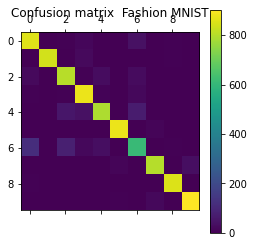

In [ ]:

test(ens,test_dataloader)

In [ ]:
## codes below are just for rough 

In [ ]:
#training a binnary classifier for label 6


labels2.mean()

0.1

In [ ]:
labels2 = labels2.tolist()

In [ ]:
a = [2,3,4]
a.index

In [ ]:
labels2[9]

AttributeError: ignored

In [ ]:
data2,label2 = binary_oversample(data,labels,class_index = 1,size=10000)

In [ ]:
label2.mean()

0.5

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])